# Modeling of duration esitmation under memory load

## Model structure

1. Duration Encoding

Given that scalar property is the key feature of duration estimation, the sensory measure (S) is assumed to be a log-scale of physical duration (D):

$$S = \log(D) + \epsilon$$

where $\epsilon$ is the noise term. 

The encoding is influenced by memory load (M) and the encoding function is assumed to be Gausian - $S_{wm} ~ N(\mu_{wm}, \sigma_{wm}^2)$, where $\mu_{wm}$ and $\sigma_{wm}^2$ are the mean and variance of the encoding function.

$$\mu_{wm} = \log{D} - k_sM$$

$$\sigma_{wm}^2 = \sigma_s^2 (1+ l_s\cdot \log(M+T_g))$$

where M represents the set size of the working memory task, T is the retention interval (gap) and $[k_s, l_s, t_s]$ are the scaling factors, $\sigma_s^2$ is the variance of the sensory measure.



## 2. Bayesian integration

Given all trials were randomly intermixed, the posterior probability of the duration estimate is given by $N(\mu_{post}, \sigma_{post}^2)$, where $\mu_{post}$ and $\sigma_{post}^2$ are the mean and variance of the posterior distribution. According to the Bayesian integration theory, the posterior distribution is a weighted sum of the sensory measure and the prior distribution:

$$\mu'_{post} = (1-w_p)\mu_{wm} + w_p\mu_{prior}$$

where
$w_p = \frac{1/\sigma_{prior}^2}{1/\sigma_{wm}^2 + 1/\sigma_{prior}^2}$.


## 3. Duration Reproduction

Having to maintain a number (‘load’) of items in working memory during the duration-reproduction phase would influence the monitoring of the elapsed time of the reproduction. Conceiving of the monitoring of the sensory ‘elapsed time’ (i.e., the time from the starting key press onwards), $\mu_{elapsed}$, as involving the counting of ‘clock ticks’ by an accumulator, lapses and diversion of attention to other, non-temporal processes would result in some ticks being lost, or missed, in the count. Here we assume that the loss is proportional to the memory load, that is: $\mu_{elapsed}-k_rM$, where $k_r$ is a scaling factor. The decision to then release the reproduction key is determined by the comparison between the perceived ‘elapsed time’ and the memorized target duration, $μ'_{post}$:

$$|\mu'_{post}-(\mu_{elapsed}-k_rM)|< \delta $$

which is equivalent to comparing the sensory elapsed time to $\mu'_{post}+k_rM$. 		

We transfer logscal to linear scale:

$$\mu_r = e^{\mu'_{post}+k_rM + {\sigma'}_{post}^2/2}$$

$$\sigma_r^2 = |e^{\sigma_{post}^2} -1|e^{2(\mu_{post}+k_rM)+{\sigma'}_{post}^2}$$

where $\mu_r$ and $\sigma_r^2$ are the mean and variance of the reproduction distribution.

The impact of non-temporal noise will be reduced as duration increases, and we assume:

$$\sigma_{observed}^2 = \sigma_r^2 + \sigma_{non-temporal}^2/D$$

where $\sigma_{non-temporal}^2$ is the variance of the non-temporal noise.

## PYMC Model

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# print the date of analysis
print('Last updated on:', dt.datetime.now())

Last updated on: 2025-01-21 17:15:23.097866


In [3]:
# get the parent directory
cpath = os.path.dirname(os.getcwd())
# import raw data from csv file cpath + data/AllData.csv
expData = pd.read_csv(cpath + '/data/AllValidData.csv')
# additional experiment 6 : Exp6.csv
exp6 = pd.read_csv(cpath + '/data/Exp6.csv').query('valid==1')

# map the column Exp to ExpName: Exp1 -> Baseline, Exp2 -> Encoding, Exp3 -> Reproduction, Exp4 -> Both, Exp5 -> Both_gap
expData['ExpName'] = expData['Exp'].map({'Exp1': 'Baseline', 
										 'Exp2': 'Encoding', 
										 'Exp3': 'Reproduction', 
										 'Exp4': 'Both', 
										 'Exp5': 'Both_gap'})
expData.head()



,WMSize,DurLevel,TPresent,NT,NSub,curDur,repDur,WMRP,valid,stdRepDur,Exp,gap,log_RP,log_dur,Gap,ExpName
0,3,1,1,1,1,0.5,0.742038,2,1,0.203701,Exp1,1,-0.298354,-0.693147,0.5,Baseline
1,3,4,1,2,1,1.4,1.301903,1,1,0.297183,Exp1,1,0.263827,0.336472,0.5,Baseline
2,3,3,1,3,1,1.1,0.805957,1,1,0.201791,Exp1,1,-0.215724,0.095310,0.5,Baseline
3,3,5,2,4,1,1.7,1.253941,2,1,0.168043,Exp1,1,0.226292,0.530628,0.5,Baseline
4,3,4,2,5,1,1.4,0.709891,2,1,0.297183,Exp1,1,-0.342644,0.336472,0.5,Baseline


In [4]:
expData.ExpName.unique()

array(['Baseline', 'Encoding', 'Reproduction', 'Both', 'Both_gap'],
      dtype=object)

In [5]:
# find out the unique gap from ExpName Both_gap
expData[expData['ExpName'] == 'Both_gap']['gap'].unique()

array([2, 1])

In [6]:
# define PYMC partial pooling model
trace = 0
def hModel(dat, constrain):
	# prepare the data
    subid = dat.NSub - 1 # starting from index 0
    nsub = len(dat.NSub.unique())  # number of subject
    # log-transformed working memory size
    wm_idx = np.log(dat.WMSize.to_numpy())
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnRepDur = np.log(repDur)
    lnDur = np.log(durs)
    #sig_p_value = np.std(lnDur)

    niter = 2000
    # define model
    with pm.Model() as WMmodel:
        # auxiliary variables (non-centered parameterization, individual level)
        var_s = pm.HalfNormal('var_s', 1, shape = nsub) # sensory noise
        epsilon_k = pm.HalfNormal('epsilon_k', 3, shape = nsub)
        if constrain[0] == 1:
            k_s0 = pm.HalfNormal('k_s',1) # working memory coeff. on ticks
            k_s =  k_s0 * epsilon_k 
        else:
            k_s = np.zeros(nsub)
        if constrain[1] == 1:
            l_s0 = pm.HalfNormal('l_s',1) # working memory impacts on variance
            l_s = l_s0 * epsilon_k
        else:
            l_s = np.zeros(nsub)
        if constrain[2] == 1:
            wm_sig = np.log(dat.WMSize.to_numpy() + dat.gap.to_numpy()-1) # only for the gap manipulation 
        else:
            wm_sig = np.log(dat.WMSize.to_numpy())
                  
        if constrain[3] == 1:
            k_r0 = pm.Normal('k_r', 0, sigma = 1) # working memory influence on reproduction 
            k_r =  k_r0 * epsilon_k
        else:
            k_r = np.zeros(nsub) 

        # prior (internal log encoding)
        epsilon = pm.HalfNormal('epsilon', 3, shape = nsub)
        mu_p = pm.Normal('mu_p', 0, sigma = 1, shape = nsub) # in log space
        var_p0 = pm.HalfNormal('var_p', 1) # in log-space
        var_p = var_p0 * epsilon

        sig_n0 = pm.HalfNormal('sig_n', 1)
        var_n = sig_n0 * epsilon
        
        # sensory measurement with log encoding + ticks loss by memory task
        # D = D_s(1+k*wm)
        # log(D) = log(D_s) + log(1+k*wm)
        # log(D) = log(D_s)(1+ + klog(wm))
        D_s = lnDur - k_s[subid] * wm_idx

        var_wm = var_s[subid] *(1+ l_s[subid] * wm_sig)
        # integration with prior
        w_p = var_wm / (var_p[subid] + var_wm)
        # posterior
        u_x = (1-w_p)*D_s + w_p * mu_p[subid] # posterior mean

        var_x = var_wm* var_p[subid]/(var_wm+var_p[subid])  # posterior variance
        # reproduction
        # reproduced duration
        u_x1 = u_x + k_r[subid]*wm_idx
        u_r = np.exp(u_x1 + var_x/2) # reproduced duration with corrupted from memory task
        #reproduced sigmas
        sig_r = np.sqrt((np.exp(var_x)-1)*np.exp(2*(u_x1) +var_x ) + var_n[subid]/durs)

        # Data likelihood 
        resp_like = pm.Normal('resp_like', mu = u_r, sigma = sig_r, observed = repDur)

        trace = pm.sample(draws=niter, tune = 1000, progressbar=True, return_inferencedata=True, target_accept=0.85)
                  
    return  trace, WMmodel	




In [7]:

# define a function to calculate the mean and sd of posterior samples for each subject
def getPosteriorSummary(posterior_samples, dat):
	# create a dataframe for mean posterior samples with following columns: NSub, curDur, WMSize, mPred, sdPred
	posterior_df = pd.DataFrame(columns = ['NSub', 'curDur', 'WMSize', 'mPred', 'sdPred'])
	# from dat get unique NSub, curDur, WMSize, and loop through them and select rows from dat
	nsub = len(dat.NSub.unique())
	nDur = len(dat.curDur.unique())
	nWM = len(dat.WMSize.unique())
	for i in range(nsub):
		for j in range(nDur):
			for k in range(nWM):
				subid = i
				curDur = dat.curDur.unique()[j]
				WMSize = dat.WMSize.unique()[k]
				idx = (dat.NSub == subid) & (dat.curDur == curDur) & (dat.WMSize == WMSize)
				if np.sum(idx) > 0:
					#log scale to linear scale
					mPred = np.mean(posterior_samples[:, idx])
					sdPred = np.std(posterior_samples[:, idx])
					df = pd.DataFrame({'NSub': subid, 'curDur': curDur, 'WMSize': WMSize, 'mPred': mPred, 'sdPred': sdPred}, index = [0])
					# concatenate the dataframe
					posterior_df = pd.concat([posterior_df, df], ignore_index = True)
	# calculate the observed means and standard deviations
	mdat = dat.groupby(['NSub', 'curDur', 'WMSize']).agg(
		repDur_mean=('repDur', 'mean'),
		repDur_std=('repDur', 'std')
	).reset_index()

	# Perform the merge with the posterior dataframe on the common keys
	mdat = pd.merge(mdat, posterior_df, on=['NSub', 'curDur', 'WMSize'])

	# Calculate repErr, predErr, repCV, and predCV
	mdat['repErr'] = mdat['repDur_mean'] - mdat['curDur']
	mdat['predErr'] = mdat['mPred'] - mdat['curDur']
	mdat['repCV'] = mdat['repDur_std'] / mdat['repDur_mean']
	mdat['predCV'] = mdat['sdPred'] / mdat['mPred']
	return mdat

# Define a customized color palette for the plot
customized_palette = sns.color_palette(['#d9d9d9', '#838383', '#3b3b3b'])

# define a function to plot oberved and predicted data (bias, CV, and scatter plot)
def plotModelPred(mdat, figname='model_pred.png'):
	# Ensure WMSize is treated as a categorical variable
	mdat['WMSize'] = mdat['WMSize'].astype('category')
	# Create a figure and axes with three subplots
	fig, ax = plt.subplots(1, 3, figsize=(9, 3))
	# Set a white background with a more scientific style
	sns.set_theme(style="white", context="paper")

	# Plot the bias (fig_bias) on the left axis (ax[0])
	sns.pointplot(
		data=mdat, x='curDur', y='repErr', hue='WMSize', palette=customized_palette,
		ax=ax[0],  linestyles='', errorbar = 'se', dodge=0.2, legend=False
	)
	sns.pointplot(
		data=mdat, x='curDur', y='predErr', hue='WMSize', palette=customized_palette,
		ax=ax[0], markers='', linestyles='-', errorbar=None
	)
	# add label figname to the bottom left corner of the first axis
	ax[0].text(0.05, 0.05, figname.capitalize(), transform=ax[0].transAxes, fontsize=10, color='black')
	ax[0].set_title('Bias')
	ax[0].set_xlabel('Duration (s)')
	ax[0].set_ylabel('Rep. Bias (s)')
	ax[0].legend(title='Memory Load')
	# Plot the CV (fig_cv) on the right axis (ax[1])
	sns.pointplot(
		data=mdat, x='curDur', y='repCV', hue='WMSize', palette=customized_palette,
		ax=ax[1],  linestyles='', errorbar = 'se', dodge = 0.2, legend=False
	)
	sns.pointplot(
			data=mdat, x='curDur', y='predCV', hue='WMSize', palette=customized_palette,
			ax=ax[1], markers='', linestyles='-', errorbar = None, legend = False
		)
	ax[1].set_title('CV')
	ax[1].set_xlabel('Duration (s)')
	ax[1].set_ylabel('Mean CV')
	# Plot the scatter plot (fig_scatter) on the right axis (ax[2])
	sns.scatterplot(
		data = mdat, x = 'repErr', y = 'predErr', hue = 'WMSize', palette=customized_palette,
		ax = ax[2], legend = False)
	ax[2].set_title('Observed vs. Predicted Bias')
	ax[2].set_xlabel('Observed Bias (s)')
	ax[2].set_ylabel('Predicted Bias (s)')
	# Adjust the layout
	plt.tight_layout()
	# save the figure
	plt.savefig(cpath + '/analysis/figures/' + figname, dpi=600)
	# Show the plot
	plt.show()



#define runModel function
def runModel(dat, constrain, model_name):
	# run the model
	trace, model = hModel(dat, constrain)
	with model:
		ppc = pm.sample_posterior_predictive(trace, var_names=['resp_like'])
		posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy() # back to linear scale
		posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2]) # reshape the array
	# get the mean of posterior samples
	mdat = getPosteriorSummary(posterior_samples, dat)

	# summarize the trace
	para = az.summary(trace)

	# save the trace, model, mdat, and summary
	az.to_netcdf(trace, cpath + '/data/' + model_name + '_trace.nc')
	mdat.to_csv(cpath + '/data/' + model_name + '_mdat.csv')
	para.to_csv(cpath + '/data/' + model_name +'_para.csv')
	return  trace, model, para, mdat

## Experiments with Memory Load on Encoding


Using hierarchical Bayesian modeling, we can estimate the parameters of the model. The model is implemented in PYMC. 

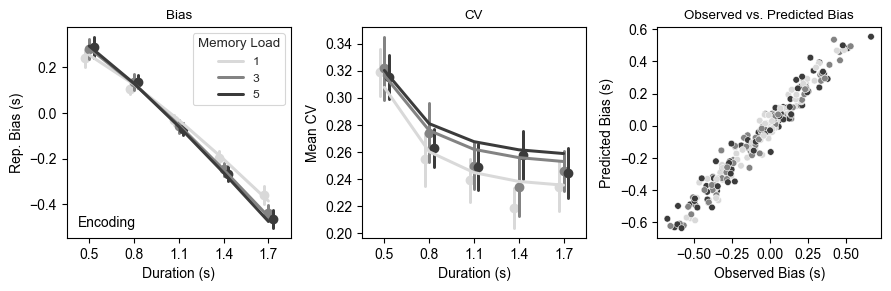

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s,0.029,0.017,0.000,0.057,0.000,0.000,2883.0,3625.0,1.0
l_s,0.215,0.067,0.101,0.338,0.001,0.001,4641.0,5251.0,1.0
k_r,0.003,0.006,-0.007,0.015,0.000,0.000,2450.0,3631.0,1.0


In [8]:
dat_encoding = expData[expData['ExpName'] == 'Encoding']
firstrun = False
if firstrun:
	constrain = [1,1,0, 1] # use all scaling parameters, ks, ls, wm_sig, and kr
	encoding_trace, encoding_model, encoding_para, encoding_mdat = runModel(dat_encoding, constrain, 'encoding')
	encoding_para
else:
	encoding_trace = az.from_netcdf(cpath + '/data/encoding_trace.nc')
	encoding_mdat = pd.read_csv(cpath + '/data/encoding_mdat.csv')
	encoding_para = pd.read_csv(cpath + '/data/encoding_para.csv')

plotModelPred(encoding_mdat, 'encoding')
az.summary(encoding_trace, var_names=['k_s','l_s','k_r'])

In [9]:
# calculate the correlation between mPred vs. repDur_mean using encoding_mdat
np.corrcoef(encoding_mdat['mPred'], encoding_mdat['repDur_mean'])


array([[1.        , 0.96651233],
       [0.96651233, 1.        ]])

In [10]:
np.corrcoef(encoding_mdat['repCV'], encoding_mdat['predCV'])

array([[1.       , 0.7022603],
       [0.7022603, 1.       ]])

## Memory Load on Reproduction


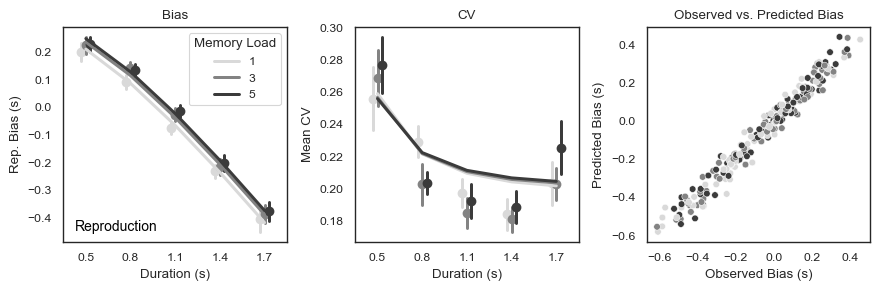

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s,0.013,0.011,0.000,0.034,0.001,0.001,584.0,170.0,1.01
l_s,0.025,0.016,0.000,0.052,0.000,0.000,2700.0,2411.0,1.00
k_r,0.021,0.008,0.009,0.035,0.000,0.000,671.0,157.0,1.01


In [11]:
dat_reproduction = expData[expData['ExpName'] == 'Reproduction']

firstrun = False
if firstrun:
	constrain = [1,1,0,1] # scaling factors 
	reproduction_trace, reproduction_model, reproduction_para, reproduction_mdat = runModel(dat_reproduction, constrain, 'reproduction')
	reproduction_para
else:
	reproduction_trace = az.from_netcdf(cpath + '/data/reproduction_trace.nc')
	reproduction_mdat = pd.read_csv(cpath + '/data/reproduction_mdat.csv')
	reproduction_para = pd.read_csv(cpath + '/data/reproduction_para.csv')
# plot the model prediction
plotModelPred(reproduction_mdat, 'reproduction')
az.summary(reproduction_trace, var_names=['k_s','l_s','k_r'])

In [10]:
np.corrcoef(reproduction_mdat['mPred'], reproduction_mdat['repDur_mean'])

array([[1.        , 0.98282206],
       [0.98282206, 1.        ]])

In [92]:
#correlation of CV
np.corrcoef(reproduction_mdat['repCV'], reproduction_mdat['predCV'])

array([[1.        , 0.54225654],
       [0.54225654, 1.        ]])

## Baseline Model

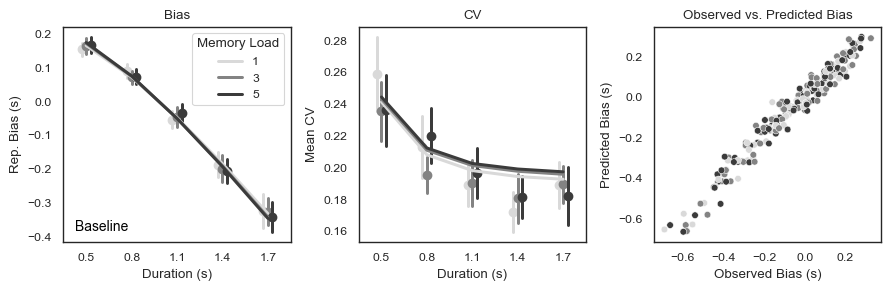

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s,0.012,0.009,0.000,0.026,0.000,0.0,2150.0,1660.0,1.0
l_s,0.032,0.022,0.000,0.069,0.001,0.0,1618.0,2421.0,1.0
k_r,0.006,0.005,-0.002,0.017,0.000,0.0,2150.0,1222.0,1.0


In [12]:
dat_baseline = expData[expData['ExpName'] == 'Baseline']
firstrun = False
if firstrun:
	constrain = [1,1,0,1] # scaling factors
	baseline_trace, baseline_model, baseline_para, baseline_mdat = runModel(dat_baseline, constrain, 'baseline')
	baseline_para
else:
	baseline_trace = az.from_netcdf(cpath + '/data/baseline_trace.nc')
	baseline_mdat = pd.read_csv(cpath + '/data/baseline_mdat.csv')
	baseline_para = pd.read_csv(cpath + '/data/baseline_para.csv')
plotModelPred(baseline_mdat, 'baseline')
az.summary(baseline_trace, var_names=['k_s','l_s', 'k_r'])

In [15]:
np.corrcoef(baseline_mdat['mPred'], baseline_mdat['repDur_mean'])

array([[1.        , 0.98836342],
       [0.98836342, 1.        ]])

In [93]:
#correlation of CV
np.corrcoef(baseline_mdat['repCV'], baseline_mdat['predCV'])

array([[1.        , 0.70305931],
       [0.70305931, 1.        ]])

## Memory Load on Encoding and Reproduction


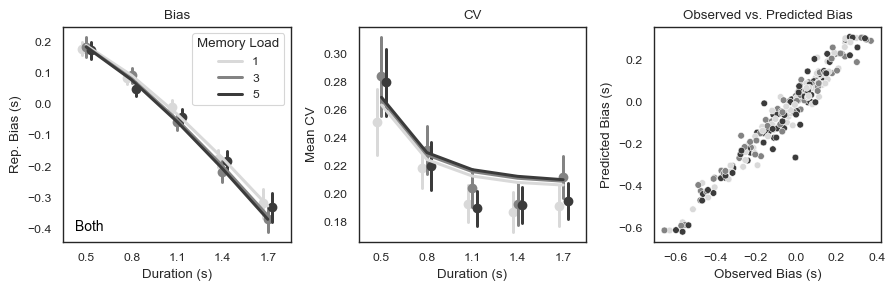

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s,0.051,0.025,0.009,0.098,0.001,0.0,1519.0,2145.0,1.0
l_s,0.027,0.019,0.000,0.060,0.000,0.0,1991.0,2794.0,1.0
k_r,0.018,0.011,-0.003,0.039,0.000,0.0,1547.0,2258.0,1.0


In [13]:
dat_both = expData[expData['ExpName'] == 'Both']
firstrun = False
if firstrun:
	constrain = [1,1,0,1] # scaling factor for k_s, l_s, gap, k_r
	both_trace, both_model, both_para, both_mdat = runModel(dat_both, constrain, 'both')
	both_para
else:
	both_trace = az.from_netcdf(cpath + '/data/both_trace.nc')
	both_mdat = pd.read_csv(cpath + '/data/both_mdat.csv')
	both_para = pd.read_csv(cpath + '/data/both_para.csv')
plotModelPred(both_mdat, 'both')
az.summary(both_trace, var_names=['k_s','l_s', 'k_r'])

In [18]:
np.corrcoef(both_mdat['mPred'], both_mdat['repDur_mean'])

array([[1.        , 0.98491326],
       [0.98491326, 1.        ]])

In [94]:
#correlation of CV
np.corrcoef(both_mdat['repCV'], both_mdat['predCV'])

array([[1.        , 0.53801413],
       [0.53801413, 1.        ]])

Plot for four experiments together

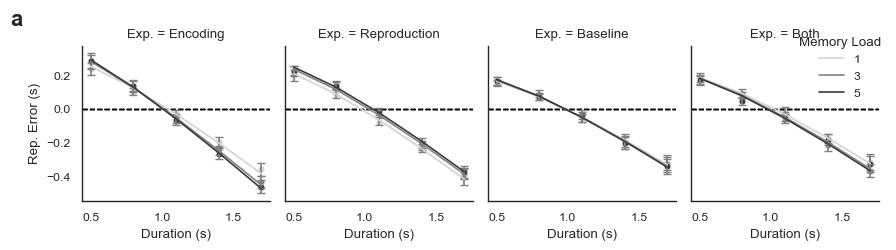

In [14]:
# combine encoding_mdat, reproduction_mdat, baseline_mdat, and both_mdat into mdat, but each data has additional column ExpName
encoding_mdat['Exp.'] = 'Encoding'
reproduction_mdat['Exp.'] = 'Reproduction'
baseline_mdat['Exp.'] = 'Baseline'
both_mdat['Exp.'] = 'Both'
exp_order = ['Encoding', 'Reproduction', 'Baseline', 'Both']
c_palette = ['lightgrey', '#838383',"#3b3b3b"] # consistent with R plot

mdat = pd.concat([encoding_mdat, reproduction_mdat, baseline_mdat, both_mdat], ignore_index=True)

# group and flatten the columns
mmdat = mdat.groupby(['curDur', 'WMSize', 'Exp.'], observed =True).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},
									'repCV': {'mean', 'sem'}, 'predCV': {'mean', 'sem'}}).reset_index()
mmdat.columns = ['_'.join(filter(None, x)).strip() for x in mmdat.columns.ravel()]	

# Create the FacetGrid, faceting on the ExpName column
g1 = sns.FacetGrid(mmdat, col="Exp.", hue="WMSize", height=2.5, aspect=0.8,col_order=exp_order, palette=c_palette)

# Map the scatter plot for reproduction error (repErr_mean)
g1.map(sns.scatterplot, 'curDur', 'repErr_mean')

# Add error bars to the scatter plots
def add_error_bars(x, y, yerr, **kwargs):
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=3, color='gray')

# Define a function to add the horizontal line at y=0
def add_hline(*args, **kwargs):
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Adds the horizontal line at y=0
# Add the horizontal line at y=0 to each subplot
g1.map(add_hline)

g1.map(add_error_bars, 'curDur', 'repErr_mean', 'repErr_sem')
# Map the line plot for predicted error (predErr_mean)
g1.map(sns.lineplot, 'curDur', 'predErr_mean')



# Customize the plot aesthetics
g1.set_axis_labels('Duration (s)', 'Rep. Error (s)')
# add legend on the top right corner
g1.add_legend(title='Memory Load')
# Adjust the legend position to the upper right corner of the entire plot
g1._legend.set_bbox_to_anchor((1, 0.9))  # Moves the legend to the upper right of the figure
g1._legend.set_loc('upper right')      # Aligns the legend to the upper right corner
# add label a to the top left corner of the first axis
g1.axes[0,0].text(0.01, 0.98, 'a', transform=g1.figure.transFigure, fontsize=16, fontweight='bold', va='top')

plt.tight_layout()
# save the figure to prediction_errors.png
plt.savefig(cpath + '/analysis/figures/prediction_errors.png')
# Show the plot

plt.show()

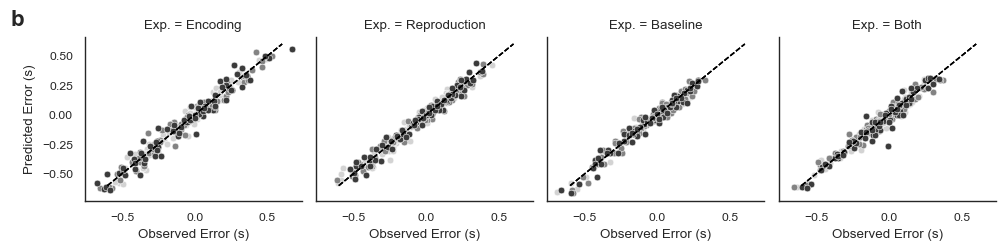

In [15]:

# Define a function to add the diagonal line
def add_diagonal(*args, **kwargs):
    ax = plt.gca()  # Get the current axis
    limits = [min(-0.6, -0.6), max(0.6, 0.6)]
    ax.plot(limits, limits, color='black', linestyle='--', linewidth=1)  # Draws the diagonal line

# now create the second pred. vs. obs. plot
# Create the FacetGrid, faceting on the ExpName column
g2 = sns.FacetGrid(mdat, col="Exp.", hue="WMSize", height=2.5, aspect=1,col_order=exp_order, palette=c_palette)
# Map the scatter plot for reproduction error (repErr_mean)
g2.map(sns.scatterplot, 'repErr', 'predErr')
# Add the diagonal line to each subplot
g2.map(add_diagonal)

# set x and y labels
g2.set_axis_labels('Observed Error (s)', 'Predicted Error (s)')
#g2.add_legend()
#g2._legend.set_title('Memory Load')
# add label a to the top left corner of the first axis
g2.axes[0,0].text(0.0, 0.98, 'b', transform=g2.fig.transFigure, fontsize=16, fontweight='bold', va='top')
# save the figure to predict_vs_obs.png
plt.savefig(cpath + '/analysis/figures/predict_vs_obs.png')


## Memory load with Gap on Encoding and Reproduction


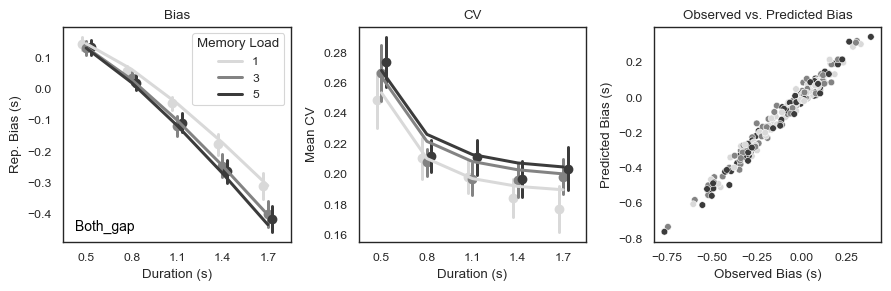

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_s,0.075,0.024,0.033,0.124,0.001,0.000,1730.0,1808.0,1.0
l_s,0.138,0.039,0.075,0.213,0.001,0.001,2605.0,3616.0,1.0
k_r,0.017,0.009,0.001,0.034,0.000,0.000,1900.0,1697.0,1.0


In [16]:
dat_gap = expData[expData['ExpName'] == 'Both_gap']
firstrun = False
if firstrun:
	constrain = [1,1,1,1] # scaling factor for k_s, l_s, gap, k_r
	both_gap_trace, both_gap_model, both_para, both_gap_mdat = runModel(dat_gap, constrain,'both_gap')
else:
	both_gap_trace = az.from_netcdf(cpath + '/data/both_gap_trace.nc')
	both_gap_mdat = pd.read_csv(cpath + '/data/both_gap_mdat.csv')
	both_gap_para = pd.read_csv(cpath + '/data/both_gap_para.csv')
plotModelPred(both_gap_mdat, 'both_gap')
az.summary(both_gap_trace, var_names=['k_s','l_s', 'k_r'])	


In [22]:
np.corrcoef(both_gap_mdat['mPred'], both_gap_mdat['repDur_mean'])

array([[1.        , 0.99242231],
       [0.99242231, 1.        ]])

In [96]:
#correlation of CV
np.corrcoef(both_gap_mdat['repCV'], both_gap_mdat['predCV'])

array([[1.        , 0.78490172],
       [0.78490172, 1.        ]])

# Within-subject Experiment 6


In [17]:
exp6.head()

,WMSize,DurLevel,TPresent,NT,NSub,curDur,repDur,repWaitTime,WMRP,WMRTTest,valid,repBias,Exp
0,5,3,2,1,1,1.1,1.045568,1.765835,-1,2.000053,1,0.241000,Exp. 6a
1,5,4,1,2,1,1.4,1.149265,0.428690,1,0.911282,1,0.176418,Exp. 6a
2,5,3,1,3,1,1.1,1.173068,0.479047,1,0.842936,1,0.241000,Exp. 6a
3,1,1,2,4,1,0.5,1.005907,0.437188,1,0.731270,1,0.251074,Exp. 6a
4,1,2,1,5,1,0.8,0.797946,0.515922,1,0.888479,1,0.182591,Exp. 6a


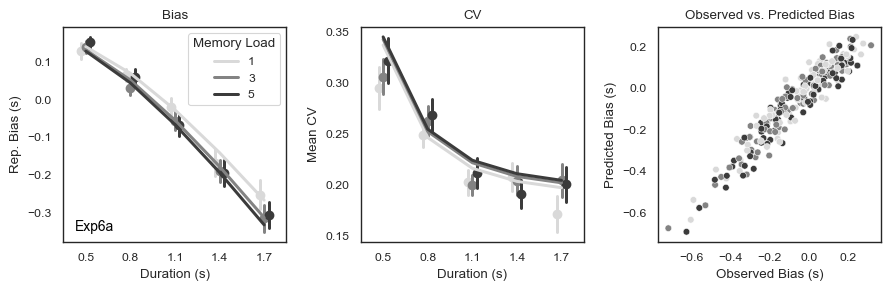

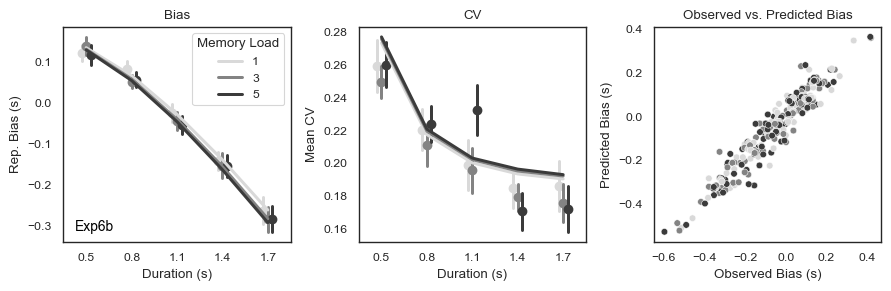

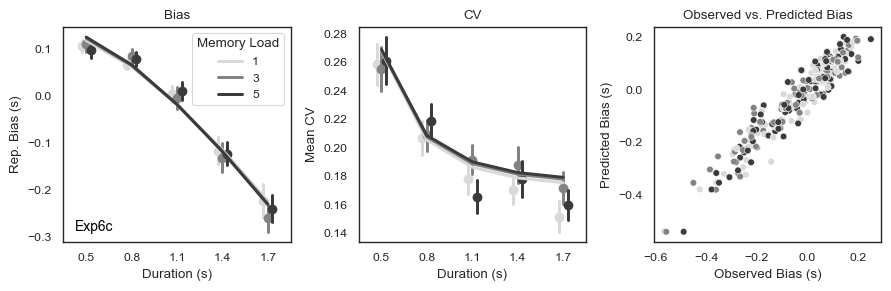

In [18]:
# model for Exp. 6a, 6b, and 6c separately, assuming without any knowledge
exp6a = exp6[exp6['Exp'] == 'Exp. 6a']
exp6b = exp6[exp6['Exp'] == 'Exp. 6b']
exp6c = exp6[exp6['Exp'] == 'Exp. 6c']

# run the model for Exp6a
constrain = [1,1,0,1] # scaling factor for k_s, l_s, gap, k_r
firstrun = False
if firstrun:
	exp6a_trace, exp6a_model, exp6a_para, exp6a_mdat = runModel(exp6a, constrain, 'exp6a')
	exp6b_trace, exp6b_model, exp6b_para, exp6b_mdat = runModel(exp6b, constrain, 'exp6b')
	exp6c_trace, exp6c_model, exp6c_para, exp6c_mdat = runModel(exp6c, constrain, 'exp6c')
else:
	exp6a_trace = az.from_netcdf(cpath + '/data/exp6a_trace.nc')
	exp6a_mdat = pd.read_csv(cpath + '/data/exp6a_mdat.csv')
	exp6b_trace = az.from_netcdf(cpath + '/data/exp6b_trace.nc')
	exp6b_mdat = pd.read_csv(cpath + '/data/exp6b_mdat.csv')
	exp6c_trace = az.from_netcdf(cpath + '/data/exp6c_trace.nc')
	exp6c_mdat = pd.read_csv(cpath + '/data/exp6c_mdat.csv')

plotModelPred(exp6a_mdat, 'exp6a')
plotModelPred(exp6b_mdat, 'exp6b')
plotModelPred(exp6c_mdat, 'exp6c')

In [20]:
np.corrcoef(exp6a_mdat['mPred'], exp6a_mdat['repDur_mean'])


array([[1.        , 0.98010853],
       [0.98010853, 1.        ]])

In [21]:
np.corrcoef(exp6b_mdat['mPred'], exp6b_mdat['repDur_mean'])


array([[1.        , 0.98545312],
       [0.98545312, 1.        ]])

In [22]:
np.corrcoef(exp6c_mdat['mPred'], exp6c_mdat['repDur_mean'])

array([[1.        , 0.98859923],
       [0.98859923, 1.        ]])

In [23]:
# correlation of CV
np.corrcoef(exp6a_mdat['repCV'], exp6a_mdat['predCV'])

array([[1.       , 0.7727757],
       [0.7727757, 1.       ]])

In [24]:
np.corrcoef(exp6b_mdat['repCV'], exp6b_mdat['predCV'])

array([[1.        , 0.65313998],
       [0.65313998, 1.        ]])

In [25]:
np.corrcoef(exp6c_mdat['repCV'], exp6c_mdat['predCV'])

array([[1.        , 0.75355892],
       [0.75355892, 1.        ]])

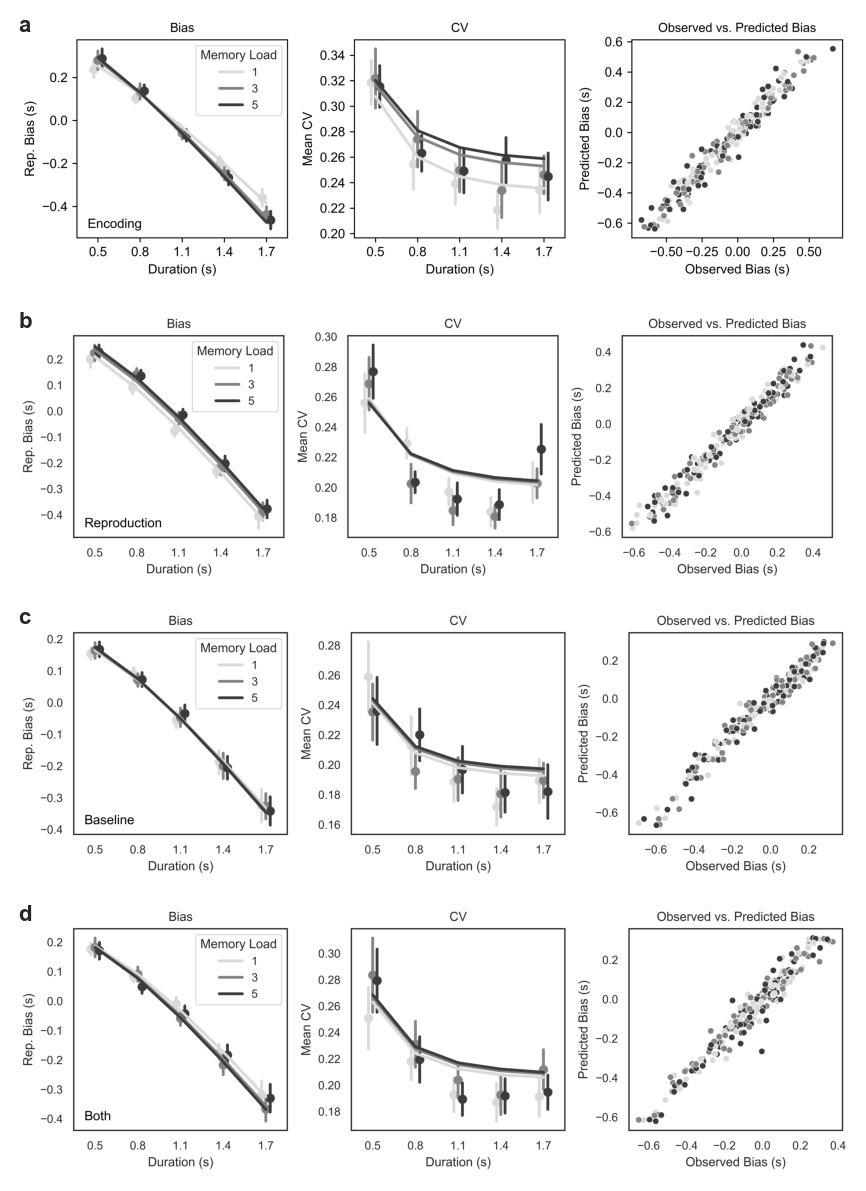

In [19]:
# combine all figures together into one figure
# read encoding.png, reproduction.png, baseline.png, both.png, both_gap.png, exp6a.png, exp6b.png, and exp6c.png
fig_encoding = plt.imread(cpath + '/analysis/figures/encoding.png')
fig_reproduction = plt.imread(cpath + '/analysis/figures/reproduction.png')
fig_baseline = plt.imread(cpath + '/analysis/figures/baseline.png')
fig_both = plt.imread(cpath + '/analysis/figures/both.png')
fig_both_gap = plt.imread(cpath + '/analysis/figures/both_gap.png')
fig_exp6a = plt.imread(cpath + '/analysis/figures/exp6a.png')
fig_exp6b = plt.imread(cpath + '/analysis/figures/exp6b.png')
fig_exp6c = plt.imread(cpath + '/analysis/figures/exp6c.png')

# create a new figure with 8 rows, and adding labels to the top left corner of each figure, a, b, c, ...
fig, ax = plt.subplots(4, 1, figsize=(9,12))
# remove the axis
for i in range(4):
	ax[i].axis('off')
# add the figures to the new figure
ax[0].imshow(fig_encoding)
ax[0].text(0.01, 0.98, 'a', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top')
ax[1].imshow(fig_reproduction)
ax[1].text(0.01, 0.98, 'b', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top')
ax[2].imshow(fig_baseline)
ax[2].text(0.01, 0.98, 'c', transform=ax[2].transAxes, fontsize=16, fontweight='bold', va='top')
ax[3].imshow(fig_both)
ax[3].text(0.01, 0.98, 'd', transform=ax[3].transAxes, fontsize=16, fontweight='bold', va='top')
plt.tight_layout()
# save the figure to all_figures.png
plt.savefig(cpath + '/analysis/figures/appendix_1.png')
# Show the plot
plt.show()



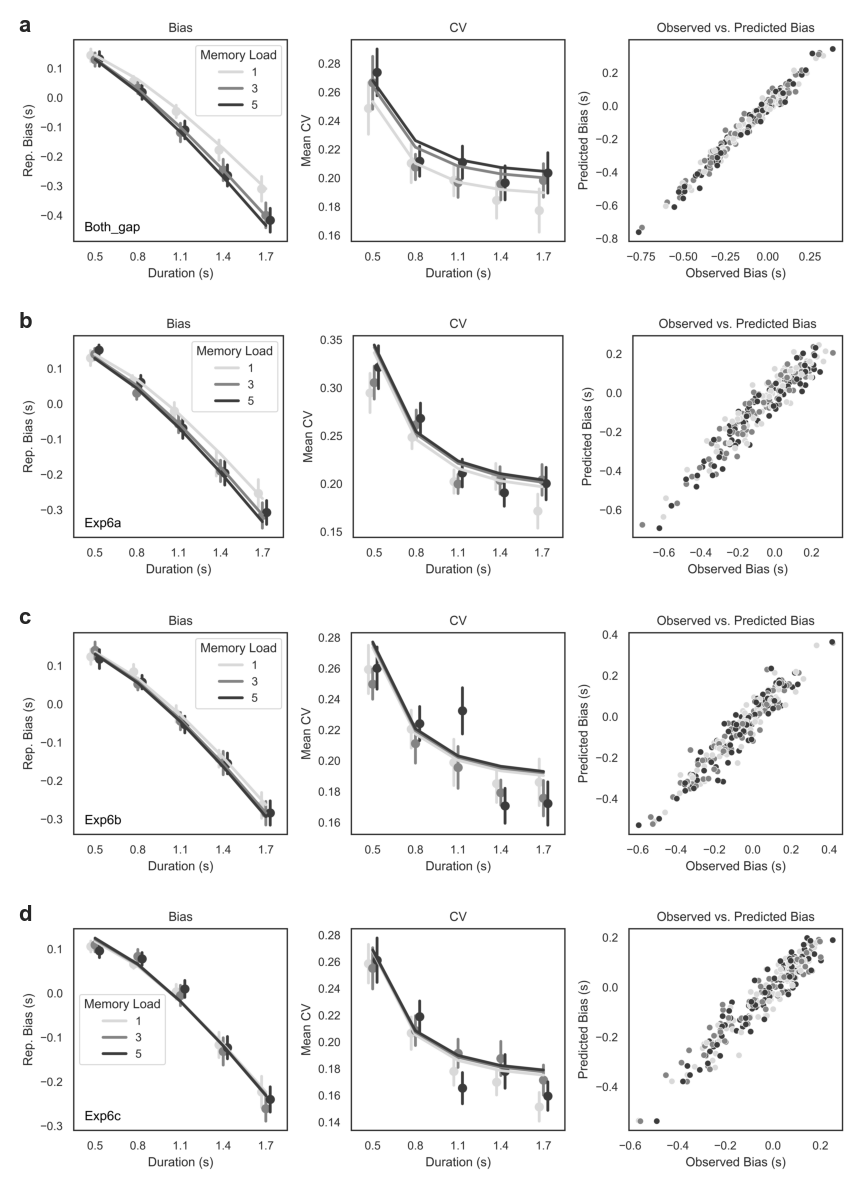

In [20]:
# same for the second figure with the rest of the figures
fig, ax = plt.subplots(4, 1, figsize=(9,12))
for i in range(4):
	ax[i].axis('off')
ax[0].imshow(fig_both_gap)
ax[0].text(0.01, 0.98, 'a', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top')
ax[1].imshow(fig_exp6a)
ax[1].text(0.01, 0.98, 'b', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top')
ax[2].imshow(fig_exp6b)
ax[2].text(0.01, 0.98, 'c', transform=ax[2].transAxes, fontsize=16, fontweight='bold', va='top')
ax[3].imshow(fig_exp6c)
ax[3].text(0.01, 0.98, 'd', transform=ax[3].transAxes, fontsize=16, fontweight='bold', va='top')
plt.tight_layout()
plt.savefig(cpath + '/analysis/figures/appendix_2.png')
plt.show()


In [21]:
def compute_subject_level_k_statistics(trace, k_param):
    """
    Computes the mean and standard deviation of k for each subject.

    Parameters:
    trace (arviz.InferenceData): The trace from the PyMC3 model, containing posterior samples.
    k_param (str): The name of the parameter (e.g., 'k_s', 'l_s', etc.).

    Returns:
    k_mean (np.ndarray): The mean of k for each subject.
    k_sd (np.ndarray): The standard deviation of k for each subject.
    """
    # Extract posterior samples for epsilon (shape: nchains, ndraws, nsub)
    epsilon_samples = trace.posterior['epsilon_k'].values  # epsilon for subjects

    # Extract posterior samples for the k parameter (shape: nchains, ndraws)
    k_samples = trace.posterior[k_param].values  # single value for k_param

    # Broadcast k_samples to match epsilon_samples' shape (nchains, ndraws, nsub)
    # We need to expand the dimension of k_samples to broadcast with epsilon_samples
    k_samples_expanded = np.expand_dims(k_samples, axis=-1)  # Add extra dimension

    # Element-wise multiplication to compute k for each subject (shape: nchains, ndraws, nsub)
    k_subject_samples = epsilon_samples * k_samples_expanded

    # Flatten the chains and draws to get all posterior samples of k for each subject
    k_subject_samples_flat = k_subject_samples.reshape(-1, k_subject_samples.shape[-1])  # (nchains*ndraws, nsub)

    # Calculate mean and standard deviation of k for each subject
    k_mean = np.mean(k_subject_samples_flat, axis=0)  # Mean for each subject
    k_sd = np.std(k_subject_samples_flat, axis=0)     # Standard deviation for each subject

    return k_mean, k_sd

# Example usage
# k_mean, k_sd = compute_subject_level_k_statistics(exp6_trace, 'k_s')
# for i, (mean, sd) in enumerate(zip(k_mean, k_sd)):
#     print(f"Subject {i+1}: Mean of k = {mean}, SD of k = {sd}")


In [22]:
#compute k statistics 
ks_exp6a, ks_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'k_s')
ks_exp6b, ks_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'k_s')
ks_exp6c, ks_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'k_s')

ls_exp6a, ls_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'l_s')
ls_exp6b, ls_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'l_s')
ls_exp6c, ls_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'l_s')

kr_exp6a, kr_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'k_r')
kr_exp6b, kr_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'k_r')
kr_exp6c, kr_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'k_r')

sn_exp6a, sn_exp6a_sd = compute_subject_level_k_statistics(exp6a_trace, 'sig_n')
sn_exp6b, sn_exp6b_sd = compute_subject_level_k_statistics(exp6b_trace, 'sig_n')
sn_exp6c, sn_exp6c_sd = compute_subject_level_k_statistics(exp6c_trace, 'sig_n')



In [23]:
# combine means together
para_exp6 = [ks_exp6a, ks_exp6b, ks_exp6c, 
			 ls_exp6a, ls_exp6b, ls_exp6c, 
			 kr_exp6a, kr_exp6b, kr_exp6c, 
			 sn_exp6a, sn_exp6b, sn_exp6c]
# reshape the array
para_exp6r = np.stack(para_exp6, axis=0).reshape(-1, 54).T

df_para_exp6 = pd.DataFrame(para_exp6r, columns = ['ks','ls','kr','sn'])
df_para_exp6['Experiment'] = ['Exp. 6a']*18 + ['Exp. 6b']*18 + ['Exp. 6c']*18
df_para_exp6['Subject'] = np.tile(np.arange(1,19), 3)
df_para_exp6.head()

,ks,ls,kr,sn,Experiment,Subject
0,0.009100,0.037635,-0.006127,0.005412,Exp. 6a,1
1,0.012062,0.047166,-0.007921,0.007060,Exp. 6a,2
2,0.028074,0.102434,-0.015643,0.014895,Exp. 6a,3
3,0.004681,0.021283,-0.003511,0.002977,Exp. 6a,4
4,0.012407,0.049134,-0.007560,0.006983,Exp. 6a,5


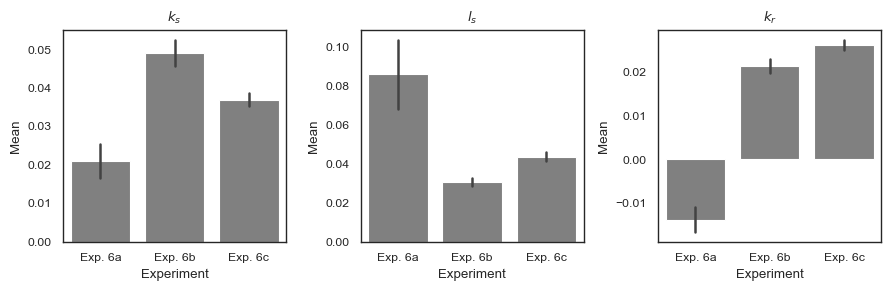

In [24]:
#plot mean and SEs of k_s, l_s, k_r, and sig_n as a function of Experiment
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.barplot(data=df_para_exp6, x='Experiment', y='ks', errorbar='se', ax=ax[0], color='gray')
ax[0].set_title(r'$k_s$')
ax[0].set_ylabel('Mean')
ax[0].set_xlabel('Experiment')

sns.barplot(data=df_para_exp6, x='Experiment', y='ls', errorbar='se', ax=ax[1], color='gray')
ax[1].set_title('$l_s$')
ax[1].set_ylabel('Mean')
ax[1].set_xlabel('Experiment')

sns.barplot(data=df_para_exp6, x='Experiment', y='kr', errorbar='se', ax=ax[2], color='gray')
ax[2].set_title('$k_r$')
ax[2].set_ylabel('Mean')
ax[2].set_xlabel('Experiment')
plt.tight_layout()
plt.savefig(cpath + '/analysis/figures/exp6_parameters.png', dpi = 600)

Note: Visual differences, $l_s$ was higher for Exp. 6a than others, while $k_r$ was close to zero for Exp. 6a. 

In [25]:
# one-way anova test for k_s, factor is Experiment, with data df_para
import pingouin as pg
aov = pg.anova(data=df_para_exp6, dv='ks', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,0.007126,2,0.003563,17.461355,0.000002,0.406443
1,Within,0.010407,51,0.000204,NaN,NaN,NaN


In [26]:
# post-hoc test for k_s
posthoc = pg.pairwise_tests(data=df_para_exp6, dv='ks', between='Experiment', padjust='holm')
posthoc.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Exp. 6a,Exp. 6b,False,True,-5.033,34.0,two-sided,0.000,0.000,holm,1073.724,-1.640
1,Experiment,Exp. 6a,Exp. 6c,False,True,-3.343,34.0,two-sided,0.002,0.004,holm,17.525,-1.089
2,Experiment,Exp. 6b,Exp. 6c,False,True,3.212,34.0,two-sided,0.003,0.004,holm,13.236,1.047


In [27]:
aov = pg.anova(data=df_para_exp6, dv='ls', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,0.030314,2,0.015157,7.913553,0.001016,0.236837
1,Within,0.097682,51,0.001915,NaN,NaN,NaN


In [28]:
# post hoc test for l_s
posthoc = pg.pairwise_tests(data=df_para_exp6, dv='ls', between='Experiment', padjust='holm')
posthoc.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Exp. 6a,Exp. 6b,False,True,3.133,34.0,two-sided,0.004,0.007,holm,11.213,1.021
1,Experiment,Exp. 6a,Exp. 6c,False,True,2.391,34.0,two-sided,0.022,0.022,holm,2.735,0.779
2,Experiment,Exp. 6b,Exp. 6c,False,True,-4.225,34.0,two-sided,0.000,0.001,holm,136.753,-1.377


In [29]:
aov = pg.anova(data=df_para_exp6, dv='kr', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,0.017019,2,0.008510,119.757544,5.398062e-20,0.82445
1,Within,0.003624,51,0.000071,NaN,NaN,NaN


In [30]:
# post hoc test for k_r
posthoc = pg.pairwise_tests(data=df_para_exp6, dv='kr', between='Experiment', padjust='holm')
posthoc.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Exp. 6a,Exp. 6b,False,True,-10.858,34.0,two-sided,0.000,0.000,holm,3.468e+09,-3.539
1,Experiment,Exp. 6a,Exp. 6c,False,True,-12.981,34.0,two-sided,0.000,0.000,holm,3.733e+11,-4.231
2,Experiment,Exp. 6b,Exp. 6c,False,True,-2.461,34.0,two-sided,0.019,0.019,holm,3.084,-0.802


In [31]:
ks_encoding, ks_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_s')
ls_encoding, ls_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'l_s')
kr_encoding, kr_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'k_r')
sn_encoding, sn_encoding_sd = compute_subject_level_k_statistics(encoding_trace, 'sig_n')

ks_reproduction, ks_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_s')
ls_reproduction, ls_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'l_s')
kr_reproduction, kr_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'k_r')
sn_reproduction, sn_reproduction_sd = compute_subject_level_k_statistics(reproduction_trace, 'sig_n')

ks_both, ks_both_sd = compute_subject_level_k_statistics(both_trace, 'k_s')
ls_both, ls_both_sd = compute_subject_level_k_statistics(both_trace, 'l_s')
kr_both, kr_both_sd = compute_subject_level_k_statistics(both_trace, 'k_r')
sn_both, sn_both_sd = compute_subject_level_k_statistics(both_trace, 'sig_n')

ks_both_gap, ks_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_s')
ls_both_gap, ls_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'l_s')
kr_both_gap, kr_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'k_r')
sn_both_gap, sn_both_gap_sd = compute_subject_level_k_statistics(both_gap_trace, 'sig_n')

ks_baseline, ks_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_s')
ls_baseline, ls_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'l_s')
kr_baseline, kr_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'k_r')
sn_baseline, sn_baseline_sd = compute_subject_level_k_statistics(baseline_trace, 'sig_n')


In [32]:
# combine means together
para = [ks_encoding, ks_reproduction, ks_both, ks_both_gap, ks_baseline,
		ls_encoding, ls_reproduction, ls_both, ls_both_gap, ls_baseline,
		kr_encoding, kr_reproduction, kr_both, kr_both_gap, kr_baseline,
		sn_encoding, sn_reproduction, sn_both, sn_both_gap, sn_baseline]
# reshape the array, each array has (16,)
para_r = np.stack(para, axis=0).reshape(-1, 80).T
# create a dataframe
df_para = pd.DataFrame(para_r, columns = ['ks','ls','kr','sn'])
df_para['Experiment'] = ['Encoding']*16 + ['Reproduction']*16 + ['Both']*16 + ['Both_gap']*16 + ['Baseline']*16
df_para.head()


,ks,ls,kr,sn,Experiment
0,0.020889,0.153211,0.002181,0.003064,Encoding
1,0.014991,0.113492,0.001617,0.002266,Encoding
2,0.043246,0.330298,0.003778,0.006480,Encoding
3,0.051731,0.379947,0.005279,0.007515,Encoding
4,0.084706,0.605442,0.010383,0.011521,Encoding


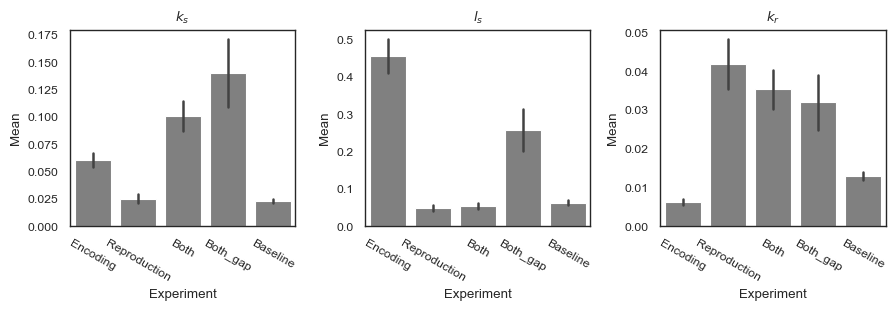

In [33]:
#plot mean and SEs of k_s, l_s, k_r, and sig_n as a function of Experiment
fig, ax = plt.subplots(1, 3, figsize=(9, 3.2))
sns.barplot(data=df_para, x='Experiment', y='ks', errorbar='se', ax=ax[0], color='gray')
ax[0].set_title('$k_s$')
ax[0].set_ylabel('Mean')
ax[0].set_xlabel('Experiment')
ax[0].tick_params(axis='x', rotation=-30)

sns.barplot(data=df_para, x='Experiment', y='ls', errorbar='se', ax=ax[1], color='gray')
ax[1].set_title('$l_s$')
ax[1].set_ylabel('Mean')
ax[1].set_xlabel('Experiment')
ax[1].tick_params(axis='x', rotation=-30)

sns.barplot(data=df_para, x='Experiment', y='kr', errorbar='se', ax=ax[2], color='gray')
ax[2].set_title('$k_r$')
ax[2].set_ylabel('Mean')
ax[2].set_xlabel('Experiment')
ax[2].tick_params(axis='x', rotation=-30)
plt.tight_layout()
plt.savefig(cpath + '/analysis/figures/exp15_parameters.png', dpi = 600)


In [34]:
# one-way anova test for k_s, factor is Experiment, with data df_para
import pingouin as pg
aov = pg.anova(data=df_para, dv='ks', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,0.162156,4,0.040539,10.407317,9.277432e-07,0.356937
1,Within,0.292143,75,0.003895,NaN,NaN,NaN


In [35]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ks', between='Experiment', padjust='holm')
posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Baseline,Both,False,True,-5.516703,30.0,two-sided,0.000005,0.000049,holm,2665.452,-1.901278
1,Experiment,Baseline,Both_gap,False,True,-3.760684,30.0,two-sided,0.000734,0.004403,holm,39.892,-1.296083
2,Experiment,Baseline,Encoding,False,True,-5.766801,30.0,two-sided,0.000003,0.000027,holm,4977.718,-1.987472
3,Experiment,Baseline,Reproduction,False,True,-0.522732,30.0,two-sided,0.605000,0.605000,holm,0.374,-0.180155
4,Experiment,Both,Both_gap,False,True,-1.147854,30.0,two-sided,0.260100,0.520201,holm,0.555,-0.395597
5,Experiment,Both,Encoding,False,True,2.626382,30.0,two-sided,0.013458,0.053832,holm,4.052,0.905157
6,Experiment,Both,Reproduction,False,True,5.191577,30.0,two-sided,0.000014,0.000108,holm,1188.547,1.789227
7,Experiment,Both_gap,Encoding,False,True,2.507664,30.0,two-sided,0.017796,0.053832,holm,3.295,0.864242
8,Experiment,Both_gap,Reproduction,False,True,3.664241,30.0,two-sided,0.000952,0.004760,holm,32.247,1.262845
9,Experiment,Encoding,Reproduction,False,True,4.742993,30.0,two-sided,0.000048,0.000337,holm,395.711,1.634627


In [36]:
aov = pg.anova(data=df_para, dv='ls', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,2.051172,4,0.512793,29.417825,1.029447e-14,0.610736
1,Within,1.307353,75,0.017431,NaN,NaN,NaN


In [37]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='ls', between='Experiment', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Baseline,Both,False,True,0.932,30.0,two-sided,0.359,0.717,holm,0.469,0.321
1,Experiment,Baseline,Both_gap,False,True,-3.400,30.0,two-sided,0.002,0.010,holm,18.275,-1.172
2,Experiment,Baseline,Encoding,False,True,-8.542,30.0,two-sided,0.000,0.000,holm,4.444e+06,-2.944
3,Experiment,Baseline,Reproduction,False,True,1.304,30.0,two-sided,0.202,0.607,holm,0.641,0.449
4,Experiment,Both,Both_gap,False,True,-3.549,30.0,two-sided,0.001,0.008,holm,25.122,-1.223
5,Experiment,Both,Encoding,False,True,-8.712,30.0,two-sided,0.000,0.000,holm,6.62e+06,-3.003
6,Experiment,Both,Reproduction,False,True,0.403,30.0,two-sided,0.690,0.717,holm,0.358,0.139
7,Experiment,Both_gap,Encoding,False,True,-2.723,30.0,two-sided,0.011,0.043,holm,4.82,-0.938
8,Experiment,Both_gap,Reproduction,False,True,3.618,30.0,two-sided,0.001,0.008,holm,29.144,1.247
9,Experiment,Encoding,Reproduction,False,True,8.782,30.0,two-sided,0.000,0.000,holm,7.785e+06,3.027


In [38]:
aov = pg.anova(data=df_para, dv='kr', between='Experiment', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Experiment,0.014930,4,0.003733,9.847852,0.000002,0.344356
1,Within,0.028427,75,0.000379,NaN,NaN,NaN


In [39]:
# post hoc comparison to the Baseline
posthoc = pg.pairwise_tests(data=df_para, dv='kr', between='Experiment', padjust='holm')
# output the posthoc with precision 3
posthoc.round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Experiment,Baseline,Both,False,True,-4.421,30.0,two-sided,0.000,0.001,holm,182.738,-1.524
1,Experiment,Baseline,Both_gap,False,True,-2.665,30.0,two-sided,0.012,0.049,holm,4.342,-0.919
2,Experiment,Baseline,Encoding,False,True,5.232,30.0,two-sided,0.000,0.000,holm,1315.16,1.803
3,Experiment,Baseline,Reproduction,False,True,-4.427,30.0,two-sided,0.000,0.001,holm,185.04,-1.526
4,Experiment,Both,Both_gap,False,True,0.382,30.0,two-sided,0.705,0.954,holm,0.356,0.132
5,Experiment,Both,Encoding,False,True,5.766,30.0,two-sided,0.000,0.000,holm,4972.84,1.987
6,Experiment,Both,Reproduction,False,True,-0.790,30.0,two-sided,0.436,0.954,holm,0.427,-0.272
7,Experiment,Both_gap,Encoding,False,True,3.604,30.0,two-sided,0.001,0.006,holm,28.29,1.242
8,Experiment,Both_gap,Reproduction,False,True,-1.015,30.0,two-sided,0.318,0.954,holm,0.498,-0.350
9,Experiment,Encoding,Reproduction,False,True,-5.467,30.0,two-sided,0.000,0.000,holm,2354.075,-1.884
